<a href="https://colab.research.google.com/github/sara-gaballa/ADHD-detection-from-EEG-signals-using-ML-and-DL-models/blob/main/DL_with_raw_signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


##Data 2 importing

In [ ]:
import os
import pandas as pd

folder_path = '/content/drive/MyDrive/Dataset 2/data files'

In [ ]:
pip install mat73

In [ ]:
import scipy.io
import os
import numpy as np
import mat73

# Prefix and suffix of the filenames
prefix = 'd'
suffix = '.mat'
# Range of file numbers to read
start_num = 1
end_num = 7

# Initialize an empty list to store the extracted data
data_list = []

# Loop over the desired file numbers and read the corresponding .mat files
for num in range(start_num, end_num+1):
  # Construct the filename
  filename = prefix + str(num) + suffix
  filepath = os.path.join(folder_path, filename)

  # Check if file exists
  if os.path.exists(filepath):
      # Load the .mat file and extract the desired variables
      mat = mat73.loadmat(filepath)

      # Append the extracted data to the list of data
      data_list.append(np.array(mat[prefix+str(num)]))
  else:
      print('File ' + filename + ' does not exist.')

In [ ]:
# Concatente all arrays
data = data_list[0]
for i in range(1, 7):
  data = np.concatenate((data, data_list[i]))
print(data.shape)
del(data_list)

(33902, 56, 385)


In [ ]:
control_trials = 10129
ADD_trials = 13031
ADHD_trials = 10742

HC = np.zeros(control_trials)
ADHD = np.ones(ADD_trials + ADHD_trials)

y = np.concatenate((HC, ADHD))
print(y.shape);

(33902,)


##Data spliting


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten ,LSTM,RepeatVector,TimeDistributed,Bidirectional,Input,Concatenate,GRU,Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Model
from keras.optimizers import Adam
#from keras.layers import  Conv2D, MaxPooling2D
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.backend import clear_session

In [ ]:
# Data Splitting
x_train, x_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)


##DL models

In [ ]:
ne = 128
lr = 0.00001

def modeling(x_train, y_train, mod):
    clear_session()
    model = tf.keras.Sequential()

    if mod == 'BI_LSTM':
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(ne, activation='tanh', return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(ne, return_sequences=True)))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(ne, return_sequences=True)))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
        model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    elif mod == 'LSTM':
        model.add(tf.keras.layers.LSTM(ne, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))  # Adjust input shape
        model.add(tf.keras.layers.LSTM(ne, return_sequences=True))
        model.add(tf.keras.layers.LSTM(ne, return_sequences=True))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
        model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    elif mod == 'GRU':
        model.add(tf.keras.layers.GRU(ne, activation='tanh', return_sequences=True, input_shape=(x_train.shape[1], 1), reset_after=True, recurrent_activation='sigmoid'))  # Adjust input shape
        model.add(tf.keras.layers.GRU(ne, return_sequences=True, reset_after=True, recurrent_activation='sigmoid'))
        model.add(tf.keras.layers.Flatten())
        model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
        model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    elif mod == 'CNN':
        model.add(Conv1D(filters=10, kernel_size=1, strides=1, input_shape=(x_train.shape[1], x_train.shape[2])))  # Adjust input shape
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(MaxPool1D(pool_size=2, strides=2))
        model.add(Conv1D(filters=10, kernel_size=1, strides=1))
        model.add(LeakyReLU())
        model.add(MaxPool1D(pool_size=2, strides=2))
        model.add(Conv1D(filters=10, kernel_size=1, strides=1))
        model.add(LeakyReLU())
        model.add(AveragePooling1D(pool_size=2, strides=2))
        model.add(Conv1D(filters=10, kernel_size=1, strides=1))
        model.add(LeakyReLU())
        model.add(AveragePooling1D(pool_size=2, strides=2))
        model.add(Conv1D(filters=10, kernel_size=1, strides=1))
        model.add(LeakyReLU())
        model.add(GlobalAveragePooling1D())
        model.add(tf.keras.layers.Flatten())
        model.add(Dense(units=2, activation='softmax'))
        model.compile(optimizer=Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    h = model.fit(
        x_train,
        y_train,
        validation_split=0.1,
        batch_size=32,
        epochs=15,
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
        verbose=1
    )
    return model, h


##BI_LSTM

In [ ]:
import time
s_time=time.time()
model1,h1=modeling(x_train,y_train,'BI_LSTM')
e_time=time.time()

Epoch 1/15
763/763 [==============================] - 661s 848ms/step - loss: 0.6063 - accuracy: 0.6941 - val_loss: 0.5844 - val_accuracy: 0.7051
Epoch 2/15
763/763 [==============================] - 625s 819ms/step - loss: 0.5694 - accuracy: 0.7083 - val_loss: 0.5733 - val_accuracy: 0.7092
Epoch 3/15
763/763 [==============================] - 624s 818ms/step - loss: 0.5459 - accuracy: 0.7241 - val_loss: 0.5691 - val_accuracy: 0.7143
Epoch 4/15
763/763 [==============================] - 630s 825ms/step - loss: 0.5234 - accuracy: 0.7405 - val_loss: 0.5681 - val_accuracy: 0.7162
Epoch 5/15
763/763 [==============================] - 622s 816ms/step - loss: 0.5009 - accuracy: 0.7577 - val_loss: 0.5729 - val_accuracy: 0.7077
Epoch 6/15
763/763 [==============================] - 624s 818ms/step - loss: 0.4789 - accuracy: 0.7722 - val_loss: 0.5795 - val_accuracy: 0.7029
Epoch 7/15
763/763 [==============================] - 619s 811ms/step - loss: 0.4569 - accuracy: 0.7856 - val_loss: 0.5882 -

In [ ]:
time=(e_time - s_time)/60
time

94.39085512161255

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
#confusion matrix
def conf(x_test,y_test,model):
  label_encoder = LabelEncoder ()
  y_pred = model.predict(x_test,verbose=0)
  pred_class_y=[]
  for i in range(y_pred.shape[0]):
    pred_class_y.append(np.argmax(y_pred[:][i]))
  pred_class_y=np.array(pred_class_y)
  #pred_class_y=label_encoder.inverse_transform(pred_class_y)
  #y_test=label_encoder.inverse_transform(y_test)
  target=["Negative","Positive"]

  plt.figure(figsize=(10,5
                      ))
  fx=sns.heatmap(confusion_matrix(y_test,pred_class_y), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n');
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n');
  fx.xaxis.set_ticklabels(target)
  fx.yaxis.set_ticklabels(target)
  plt.show()

In [ ]:
acc=[]
precision=[]
recall=[]
f1=[]
auroc=[]
y_pred1=model1.predict(x_test,verbose=0)
y_pred=[]
for i in range(y_pred1.shape[0]):
    y_pred.append(np.argmax(y_pred1[:][i]))
y_pred=np.array(y_pred)
acc.append(accuracy_score(y_test, y_pred) )
precision.append (precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
auroc.append(roc_auc_score(y_test, y_pred))


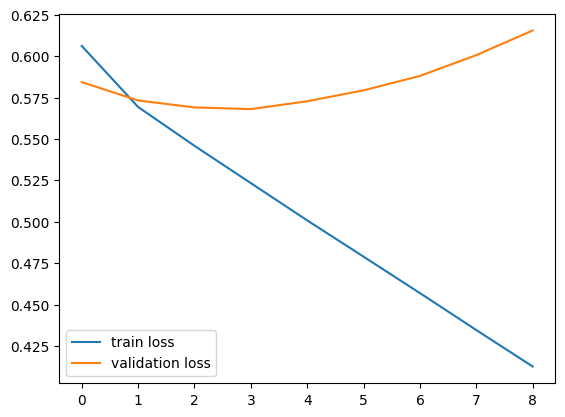

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h1.history['loss'],label="train loss")
plt.plot(h1.history['val_loss'],label='validation loss')
#plt.plot(h.history['accuracy'],label='accuracy ')
plt.legend()

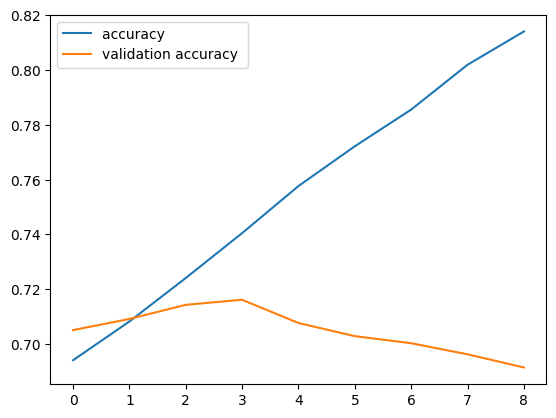

In [ ]:
plt.plot(h1.history['accuracy'],label='accuracy ')
plt.plot(h1.history['val_accuracy'],label='validation accuracy ')
plt.legend()

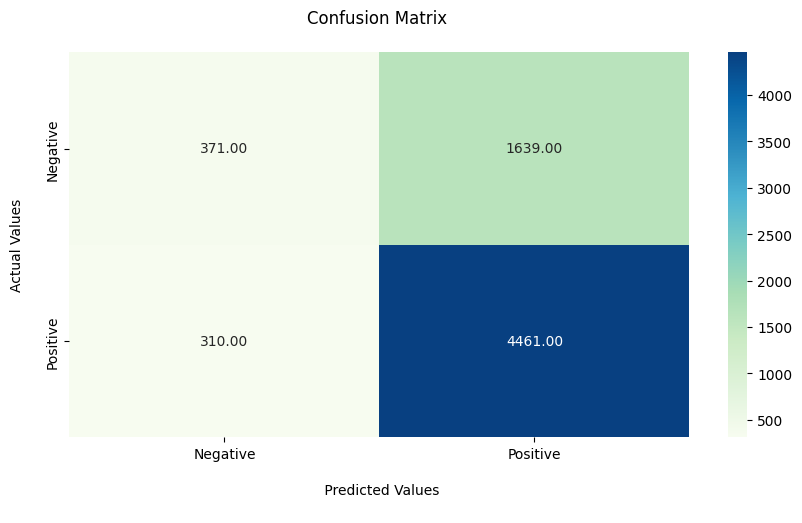

In [ ]:
from sklearn.metrics import confusion_matrix
conf(x_test,y_test,model1)

In [ ]:
models=['LSTM']
results=pd.DataFrame({'Models':models,'Accuracy':acc, 'Precision':precision,'Recall':recall,'F1':f1,'AURoc':auroc})
results

,Models,Accuracy,Precision,Recall,F1,AURoc
0,LSTM,0.712579,0.731311,0.935024,0.820716,0.559801


##CNN


In [ ]:
import time
s_time=time.time()
model1,h1=modeling(x_train,y_train,'CNN')
e_time=time.time()

Epoch 1/15
763/763 [==============================] - 23s 26ms/step - loss: 0.6566 - accuracy: 0.6974 - val_loss: 0.6060 - val_accuracy: 0.6930
Epoch 2/15
763/763 [==============================] - 25s 33ms/step - loss: 0.6028 - accuracy: 0.6968 - val_loss: 0.5960 - val_accuracy: 0.6981
Epoch 3/15
763/763 [==============================] - 22s 28ms/step - loss: 0.5915 - accuracy: 0.7008 - val_loss: 0.5889 - val_accuracy: 0.7055
Epoch 4/15
763/763 [==============================] - 20s 26ms/step - loss: 0.5836 - accuracy: 0.7048 - val_loss: 0.5837 - val_accuracy: 0.7114
Epoch 5/15
763/763 [==============================] - 19s 24ms/step - loss: 0.5762 - accuracy: 0.7113 - val_loss: 0.5801 - val_accuracy: 0.7114
Epoch 6/15
763/763 [==============================] - 24s 32ms/step - loss: 0.5711 - accuracy: 0.7128 - val_loss: 0.5780 - val_accuracy: 0.7132
Epoch 7/15
763/763 [==============================] - 19s 25ms/step - loss: 0.5671 - accuracy: 0.7166 - val_loss: 0.5741 - val_accuracy:

In [ ]:
time=(e_time - s_time)/60
time

5.547117555141449

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

#confusion matrix
def conf(x_test,y_test,model):
  label_encoder = LabelEncoder ()
  y_pred = model.predict(x_test,verbose=0)
  pred_class_y=[]
  for i in range(y_pred.shape[0]):
    pred_class_y.append(np.argmax(y_pred[:][i]))
  pred_class_y=np.array(pred_class_y)
  #pred_class_y=label_encoder.inverse_transform(pred_class_y)
  #y_test=label_encoder.inverse_transform(y_test)
  target=["Negative","Positive"]

  plt.figure(figsize=(10,5
                      ))
  fx=sns.heatmap(confusion_matrix(y_test,pred_class_y), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n');
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n');
  fx.xaxis.set_ticklabels(target)
  fx.yaxis.set_ticklabels(target)
  plt.show()

In [ ]:
acc=[]
precision=[]
recall=[]
f1=[]
auroc=[]
y_pred1=model1.predict(x_test,verbose=0)
y_pred=[]
for i in range(y_pred1.shape[0]):
    y_pred.append(np.argmax(y_pred1[:][i]))
y_pred=np.array(y_pred)
acc.append(accuracy_score(y_test, y_pred) )
precision.append (precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
auroc.append(roc_auc_score(y_test, y_pred))


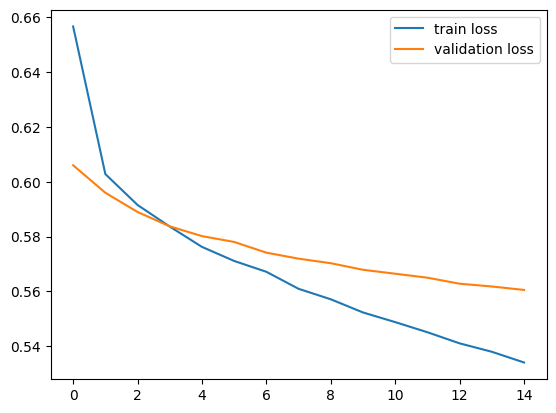

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h1.history['loss'],label="train loss")
plt.plot(h1.history['val_loss'],label='validation loss')
#plt.plot(h.history['accuracy'],label='accuracy ')
plt.legend()

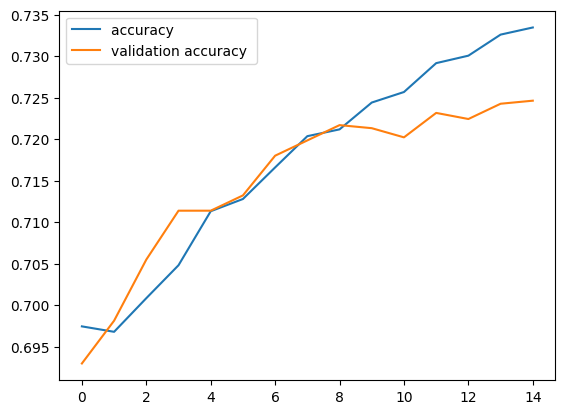

In [ ]:
plt.plot(h1.history['accuracy'],label='accuracy ')
plt.plot(h1.history['val_accuracy'],label='validation accuracy ')
plt.legend()

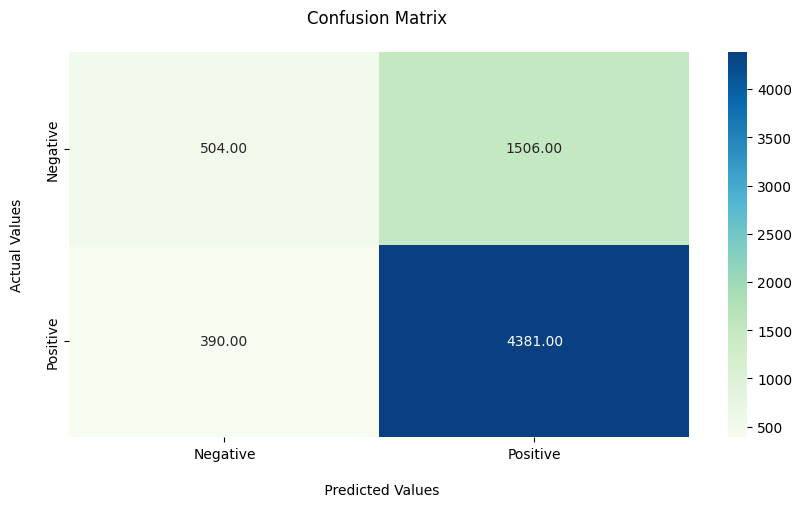

In [ ]:
from sklearn.metrics import confusion_matrix
conf(x_test,y_test,model1)

In [ ]:
models=['LSTM']
results=pd.DataFrame({'Models':models,'Accuracy':acc, 'Precision':precision,'Recall':recall,'F1':f1,'AURoc':auroc})
results

,Models,Accuracy,Precision,Recall,F1,AURoc
0,LSTM,0.720395,0.744182,0.918256,0.822105,0.584501


##GRU


In [ ]:
import time
s_time=time.time()
model1,h1=modeling(x_train,y_train,'GRU')
e_time=time.time()

Epoch 1/30
763/763 [==============================] - 166s 209ms/step - loss: 0.6744 - accuracy: 0.6318 - val_loss: 0.6262 - val_accuracy: 0.6771
Epoch 2/30
763/763 [==============================] - 156s 204ms/step - loss: 0.6121 - accuracy: 0.6863 - val_loss: 0.6061 - val_accuracy: 0.6919
Epoch 3/30
763/763 [==============================] - 160s 210ms/step - loss: 0.5829 - accuracy: 0.7044 - val_loss: 0.5964 - val_accuracy: 0.6970
Epoch 4/30
763/763 [==============================] - 160s 210ms/step - loss: 0.5623 - accuracy: 0.7173 - val_loss: 0.5891 - val_accuracy: 0.7048
Epoch 5/30
763/763 [==============================] - 157s 206ms/step - loss: 0.5460 - accuracy: 0.7277 - val_loss: 0.5858 - val_accuracy: 0.7114
Epoch 6/30
763/763 [==============================] - 159s 209ms/step - loss: 0.5329 - accuracy: 0.7378 - val_loss: 0.5819 - val_accuracy: 0.7136
Epoch 7/30
763/763 [==============================] - 151s 198ms/step - loss: 0.5207 - accuracy: 0.7457 - val_loss: 0.5793 -

In [ ]:
time=(e_time - s_time)/60
time

42.04162263870239

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

#confusion matrix
def conf(x_test,y_test,model):
  label_encoder = LabelEncoder ()
  y_pred = model.predict(x_test,verbose=0)
  pred_class_y=[]
  for i in range(y_pred.shape[0]):
    pred_class_y.append(np.argmax(y_pred[:][i]))
  pred_class_y=np.array(pred_class_y)
  #pred_class_y=label_encoder.inverse_transform(pred_class_y)
  #y_test=label_encoder.inverse_transform(y_test)
  target=["Negative","Positive"]

  plt.figure(figsize=(10,5
                      ))
  fx=sns.heatmap(confusion_matrix(y_test,pred_class_y), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n');
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n');
  fx.xaxis.set_ticklabels(target)
  fx.yaxis.set_ticklabels(target)
  plt.show()

In [ ]:
acc=[]
precision=[]
recall=[]
f1=[]
auroc=[]
y_pred1=model1.predict(x_test,verbose=0)
y_pred=[]
for i in range(y_pred1.shape[0]):
    y_pred.append(np.argmax(y_pred1[:][i]))
y_pred=np.array(y_pred)
acc.append(accuracy_score(y_test, y_pred) )
precision.append (precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
auroc.append(roc_auc_score(y_test, y_pred))


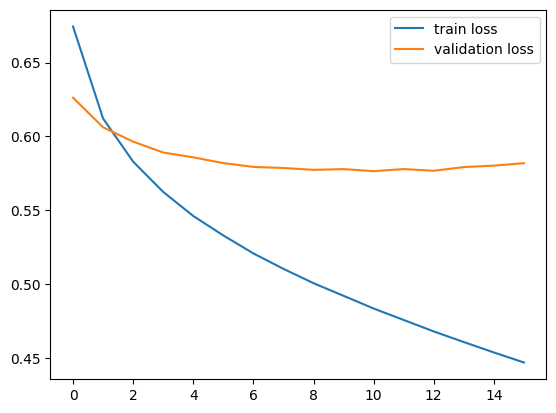

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h1.history['loss'],label="train loss")
plt.plot(h1.history['val_loss'],label='validation loss')
#plt.plot(h.history['accuracy'],label='accuracy ')
plt.legend()

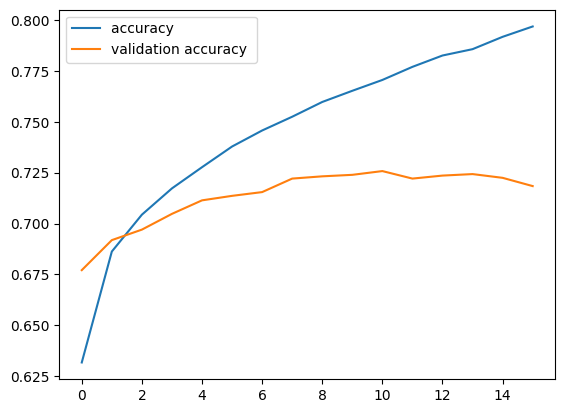

In [ ]:
plt.plot(h1.history['accuracy'],label='accuracy ')
plt.plot(h1.history['val_accuracy'],label='validation accuracy ')
plt.legend()

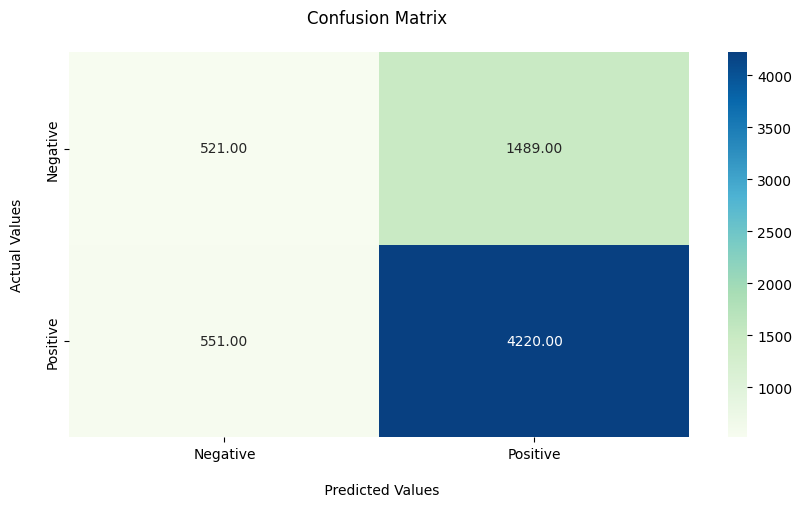

In [ ]:
from sklearn.metrics import confusion_matrix
conf(x_test,y_test,model1)

In [ ]:
models=['LSTM']
results=pd.DataFrame({'Models':models,'Accuracy':acc, 'Precision':precision,'Recall':recall,'F1':f1,'AURoc':auroc})
results

,Models,Accuracy,Precision,Recall,F1,AURoc
0,LSTM,0.699159,0.739184,0.884511,0.805344,0.571857


##LSTM

In [ ]:
import time
s_time=time.time()
model1,h1=modeling(x_train,y_train,'LSTM')
e_time=time.time()

Epoch 1/15
763/763 [==============================] - 196s 252ms/step - loss: 0.6174 - accuracy: 0.6911 - val_loss: 0.5934 - val_accuracy: 0.7048
Epoch 2/15
763/763 [==============================] - 178s 234ms/step - loss: 0.5893 - accuracy: 0.6999 - val_loss: 0.5800 - val_accuracy: 0.7088
Epoch 3/15
763/763 [==============================] - 183s 239ms/step - loss: 0.5727 - accuracy: 0.7069 - val_loss: 0.5748 - val_accuracy: 0.7154
Epoch 4/15
763/763 [==============================] - 186s 244ms/step - loss: 0.5590 - accuracy: 0.7139 - val_loss: 0.5723 - val_accuracy: 0.7151
Epoch 5/15
763/763 [==============================] - 184s 241ms/step - loss: 0.5467 - accuracy: 0.7240 - val_loss: 0.5710 - val_accuracy: 0.7132
Epoch 6/15
763/763 [==============================] - 185s 243ms/step - loss: 0.5345 - accuracy: 0.7320 - val_loss: 0.5726 - val_accuracy: 0.7191
Epoch 7/15
763/763 [==============================] - 185s 242ms/step - loss: 0.5228 - accuracy: 0.7422 - val_loss: 0.5730 -

In [ ]:
time=(e_time - s_time)/60
time

30.88138420979182

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler
from sklearn.utils import shuffle
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten ,LSTM,RepeatVector,TimeDistributed,Bidirectional,Input,Concatenate,GRU,Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Model
from keras.optimizers import Adam
#from keras.layers import  Conv2D, MaxPooling2D
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.backend import clear_session
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#confusion matrix
def conf(x_test,y_test,model):
  label_encoder = LabelEncoder ()
  y_pred = model.predict(x_test,verbose=0)
  pred_class_y=[]
  for i in range(y_pred.shape[0]):
    pred_class_y.append(np.argmax(y_pred[:][i]))
  pred_class_y=np.array(pred_class_y)
  #pred_class_y=label_encoder.inverse_transform(pred_class_y)
  #y_test=label_encoder.inverse_transform(y_test)
  target=["Negative","Positive"]

  plt.figure(figsize=(10,5
                      ))
  fx=sns.heatmap(confusion_matrix(y_test,pred_class_y), annot=True, fmt=".2f",cmap="GnBu")
  fx.set_title('Confusion Matrix \n');
  fx.set_xlabel('\n Predicted Values\n')
  fx.set_ylabel('Actual Values\n');
  fx.xaxis.set_ticklabels(target)
  fx.yaxis.set_ticklabels(target)
  plt.show()

In [ ]:
acc=[]
precision=[]
recall=[]
f1=[]
auroc=[]
y_pred1=model1.predict(x_test,verbose=0)
y_pred=[]
for i in range(y_pred1.shape[0]):
    y_pred.append(np.argmax(y_pred1[:][i]))
y_pred=np.array(y_pred)
acc.append(accuracy_score(y_test, y_pred) )
precision.append (precision_score(y_test, y_pred))
recall.append(recall_score(y_test, y_pred))
f1.append(f1_score(y_test, y_pred))
auroc.append(roc_auc_score(y_test, y_pred))

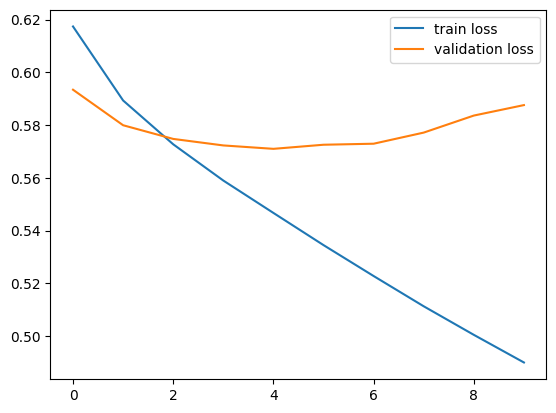

In [ ]:
import matplotlib.pyplot as plt

plt.plot(h1.history['loss'],label="train loss")
plt.plot(h1.history['val_loss'],label='validation loss')
#plt.plot(h.history['accuracy'],label='accuracy ')
plt.legend()

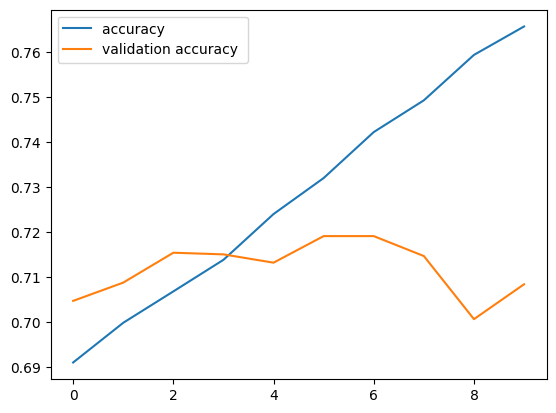

In [ ]:
plt.plot(h1.history['accuracy'],label='accuracy ')
plt.plot(h1.history['val_accuracy'],label='validation accuracy ')
plt.legend()

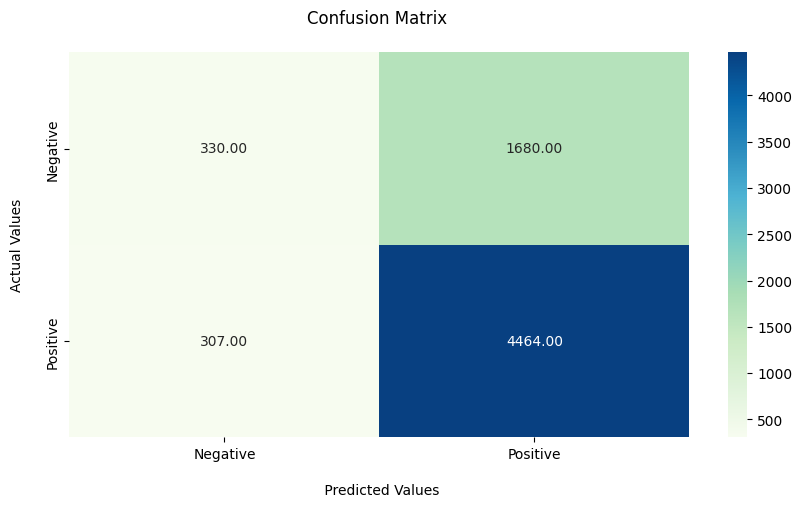

In [ ]:
from sklearn.metrics import confusion_matrix
conf(x_test,y_test,model1)

In [ ]:
models=['LSTM']
results=pd.DataFrame({'Models':models,'Accuracy':acc, 'Precision':precision,'Recall':recall,'F1':f1,'AURoc':auroc})
results

,Models,Accuracy,Precision,Recall,F1,AURoc
0,LSTM,0.706975,0.726562,0.935653,0.817957,0.549916
